In [1]:
%env GOOGLE_CLOUD_PROJECT=latent-state-learning

env: GOOGLE_CLOUD_PROJECT=latent-state-learning


In [2]:
from pprint import pprint
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

In [3]:
STORE_NEW_DATA = False

if STORE_NEW_DATA:
    import firebase_admin
    from firebase_admin import firestore

    app = firebase_admin.initialize_app()
    db = firestore.client()

In [4]:
experiments_raw = []
if STORE_NEW_DATA:
    # Fetch all the experiments
    def get_new_docs_stream():
        return db.collection("experiments").stream()

    for doc in get_new_docs_stream():
        trials = []
        for i, trial in enumerate(doc.to_dict()['trials']):
            trials.append(trial)
        experiments_raw.append({
            'experiment_id': doc.id,
            'trials': trials,
        })
    
    # Store the data in a local file
    with open('experiments_raw.json', 'w') as f:
        f.write(json.dumps(experiments_raw))
else:
    # Load the data from a local file
    with open('experiments_raw.json', 'r') as f:
        experiments_raw = json.loads(f.read())

print(f'Total number of experiments: {len(experiments_raw)}')
# pprint(experiments_raw)

Total number of experiments: 5


In [5]:
# Preprocess the experiments
experiments = []
for experiment in experiments_raw:
    trials = []
    for trial in experiment['trials']:
        preprocessed_trial = {
            **trial
        }
        if trial['trial_type'] in ['dragndrop', 'html-button-response', 'html-keyboard-response'] and 'tutorial' not in trial:
            if 'drag_data' in trial:
                drag_data = trial['drag_data'] # { "0": [{ "x": 0, "y": 0, "t": 0 }, { "x": 0, "y": 0, "t": 0 }], "1": [{ "x": 0, "y": 0, "t": 0 }, { "x": 0, "y": 0, "t": 0 }] }
                # sort by dict key
                converted_drag_data = []
                for i in range(len(drag_data)):
                    converted_drag_data.append(drag_data[str(i)])
                for i, val in enumerate(converted_drag_data):
                    converted_drag_data[i] = sorted(val, key=lambda x: x['time'])
                preprocessed_trial['drag_data'] = converted_drag_data
                
                bucks = []
                for i in range(len(trial['buckets'])):
                    bucks.append(trial['buckets'][str(i)])
                preprocessed_trial['buckets'] = bucks
                
            
            if 'webgazer_data' in trial:
                webgazer_data = trial['webgazer_data']
                webgazer_data = sorted([webgazer_data[key] for key in webgazer_data], key=lambda x: x['t'])
                preprocessed_trial['webgazer_data'] = webgazer_data
                
            if 'mouse_tracking_data' in trial:
                mouse_data = trial['mouse_tracking_data']
                mouse_data = sorted([mouse_data[key] for key in mouse_data], key=lambda x: x['t'])
                preprocessed_trial['mouse_tracking_data'] = mouse_data
            
            trials.append(preprocessed_trial)

    experiments.append({
        'experiment_id': experiment['experiment_id'],
        'trials': trials,
    })
    
pprint(experiments)

[{'experiment_id': 'G587cML7Z7SnWNWPUy4f',
  'trials': [{'internal_node_id': '0.0-1.0',
              'response': ' ',
              'rt': 111994,
              'stimulus': '<h1>Welcome to the psychiatric '
                          'experiment!</h1><p>Press any key to continue.</p>',
              'time_elapsed': 114506,
              'trial_index': 1,
              'trial_type': 'html-keyboard-response'},
             {'internal_node_id': '0.0-3.0',
              'response': 'm',
              'rt': 7767,
              'stimulus': '<h1>Fullscreen</h1>\n'
                          '<p>For best accuracy and your attention, it is '
                          'highly recommended that you play the game in '
                          'fullscreen.</p>\n'
                          '<p>Press any key to fullscreen and continue to '
                          'camera calibration.</p>',
              'time_elapsed': 144520,
              'trial_index': 3,
              'trial_type': 'html-keyboard

Visualizing drag_data experiment G587cML7Z7SnWNWPUy4f


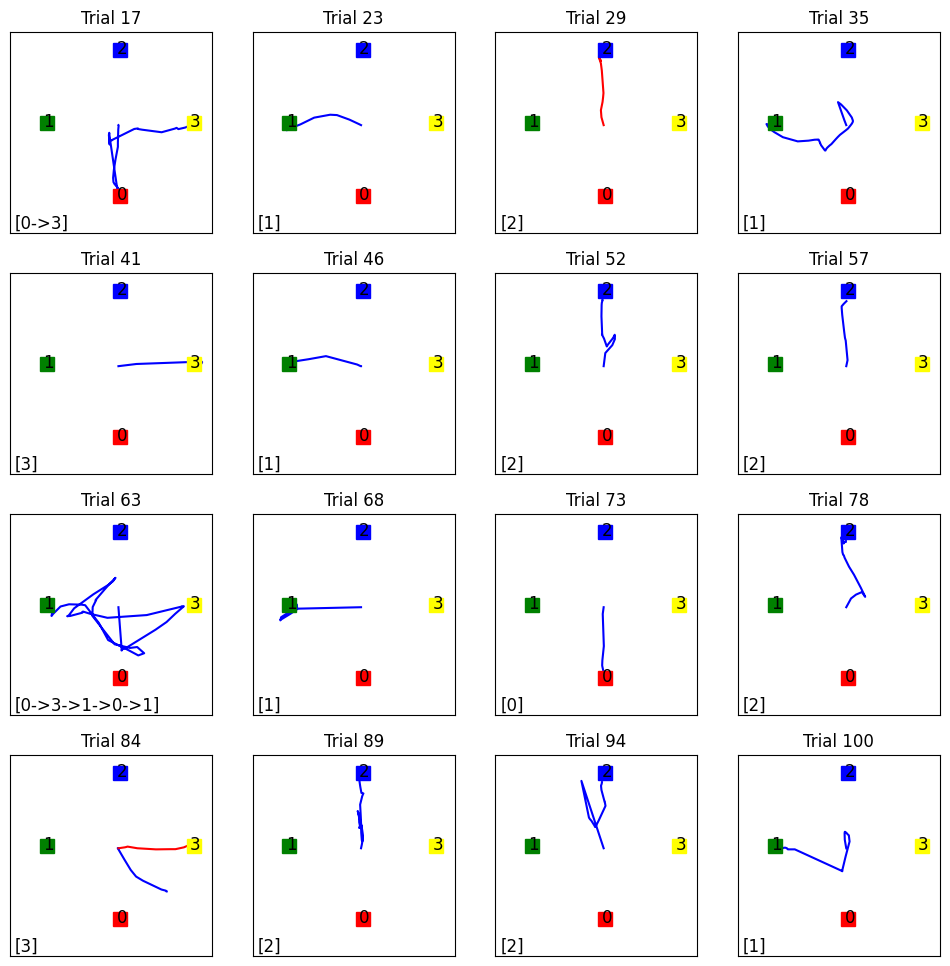

In [6]:
def visualize_experiment_drag_data(preprocessed_experiment):
    '''For each trial, show a white image where the drag data is drawn as a line'''
    print(f'Visualizing drag_data experiment {preprocessed_experiment["experiment_id"]}')
    
    n_drag_trials = sum('drag_data' in trial for trial in preprocessed_experiment['trials'])
    # print(f'Number of drag trials: {n_drag_trials}')
    cols = 4
    rows = (n_drag_trials + cols - 1) // cols
    fig, axs = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
    trial_i = 0
    for trial in preprocessed_experiment['trials']:
        if 'drag_data' in trial:
            # bucket_centers = [(bucket['x'], bucket['y']) for bucket in trial['buckets']]
            bucket_centers = [
                [593 + 200/2, -106 + 200/2],
                [193 + 200/2, 294 + 200/2],
                [593 + 200/2, 694 + 200/2],
                [993 + 200/2, 294 + 200/2],
            ]

            # TODO: transform the drag data according to bucket order
            bucket_order = trial['bucket_order'] if 'bucket_order' in trial else list(range(len(trial['buckets'])))
            bucket_colors = ['red', 'green', 'blue', 'yellow']
            bucket_dist = np.sqrt((bucket_centers[0][0] - bucket_centers[2][0])**2 + (bucket_centers[0][1] - bucket_centers[2][1])**2)
            # print(f'Bucket distance: {bucket_dist}')
            if rows == 1:
                ax = axs[trial_i % cols]
            else:
                ax = axs[trial_i // cols, trial_i % cols]
            ax.set_title(f'Trial {trial['trial_index']}')
            ax.set_xlim(min([b[0] for b in bucket_centers]) - 200, max([b[0] for b in bucket_centers]) + 100)
            ax.set_ylim(min([b[1] for b in bucket_centers]) - 200, max([b[1] for b in bucket_centers]) + 100)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

            for i, drag_data in enumerate(trial['drag_data']):
                ax.plot([d['x'] for d in drag_data], [d['y'] for d in drag_data], label='Drag data', color='blue' if i == 0 else 'red')
            trial_i += 1
            
            for i, bucket_center in enumerate(bucket_centers):
                ax.plot(bucket_center[0], bucket_center[1], 's', markersize=10, color=bucket_colors[i])
                ax.text(bucket_center[0]-20, bucket_center[1]-20, str(i), fontsize=12, color='black')

            bucket_confusions = []
            for i, drag_data in enumerate(trial['drag_data']):
                for j, point in enumerate(drag_data):
                    min_dist = float('inf')
                    min_bucket = None
                    for k, bucket_center in enumerate(bucket_centers):
                        dist = np.sqrt((point['x'] - bucket_center[0])**2 + (point['y'] - bucket_center[1])**2)
                        if dist < min_dist:
                            min_dist = dist
                            min_bucket = k
                    
                    # print(f'Point {j}: [{point['x']},{point['y']}] is closest to bucket {min_bucket} with distance {min_dist:.0f}')
                    if min_dist < bucket_dist / 4 and ((bucket_confusions and bucket_confusions[-1] != min_bucket) or not bucket_confusions):
                        bucket_confusions.append(min_bucket)
            ax.text(120, -180, '[' + '->'.join(map(str, bucket_confusions)) + ']', fontsize=12, color='black')


                
            
    plt.show()

            
visualize_experiment_drag_data(experiments[0])

Visualizing eye gaze experiment G587cML7Z7SnWNWPUy4f


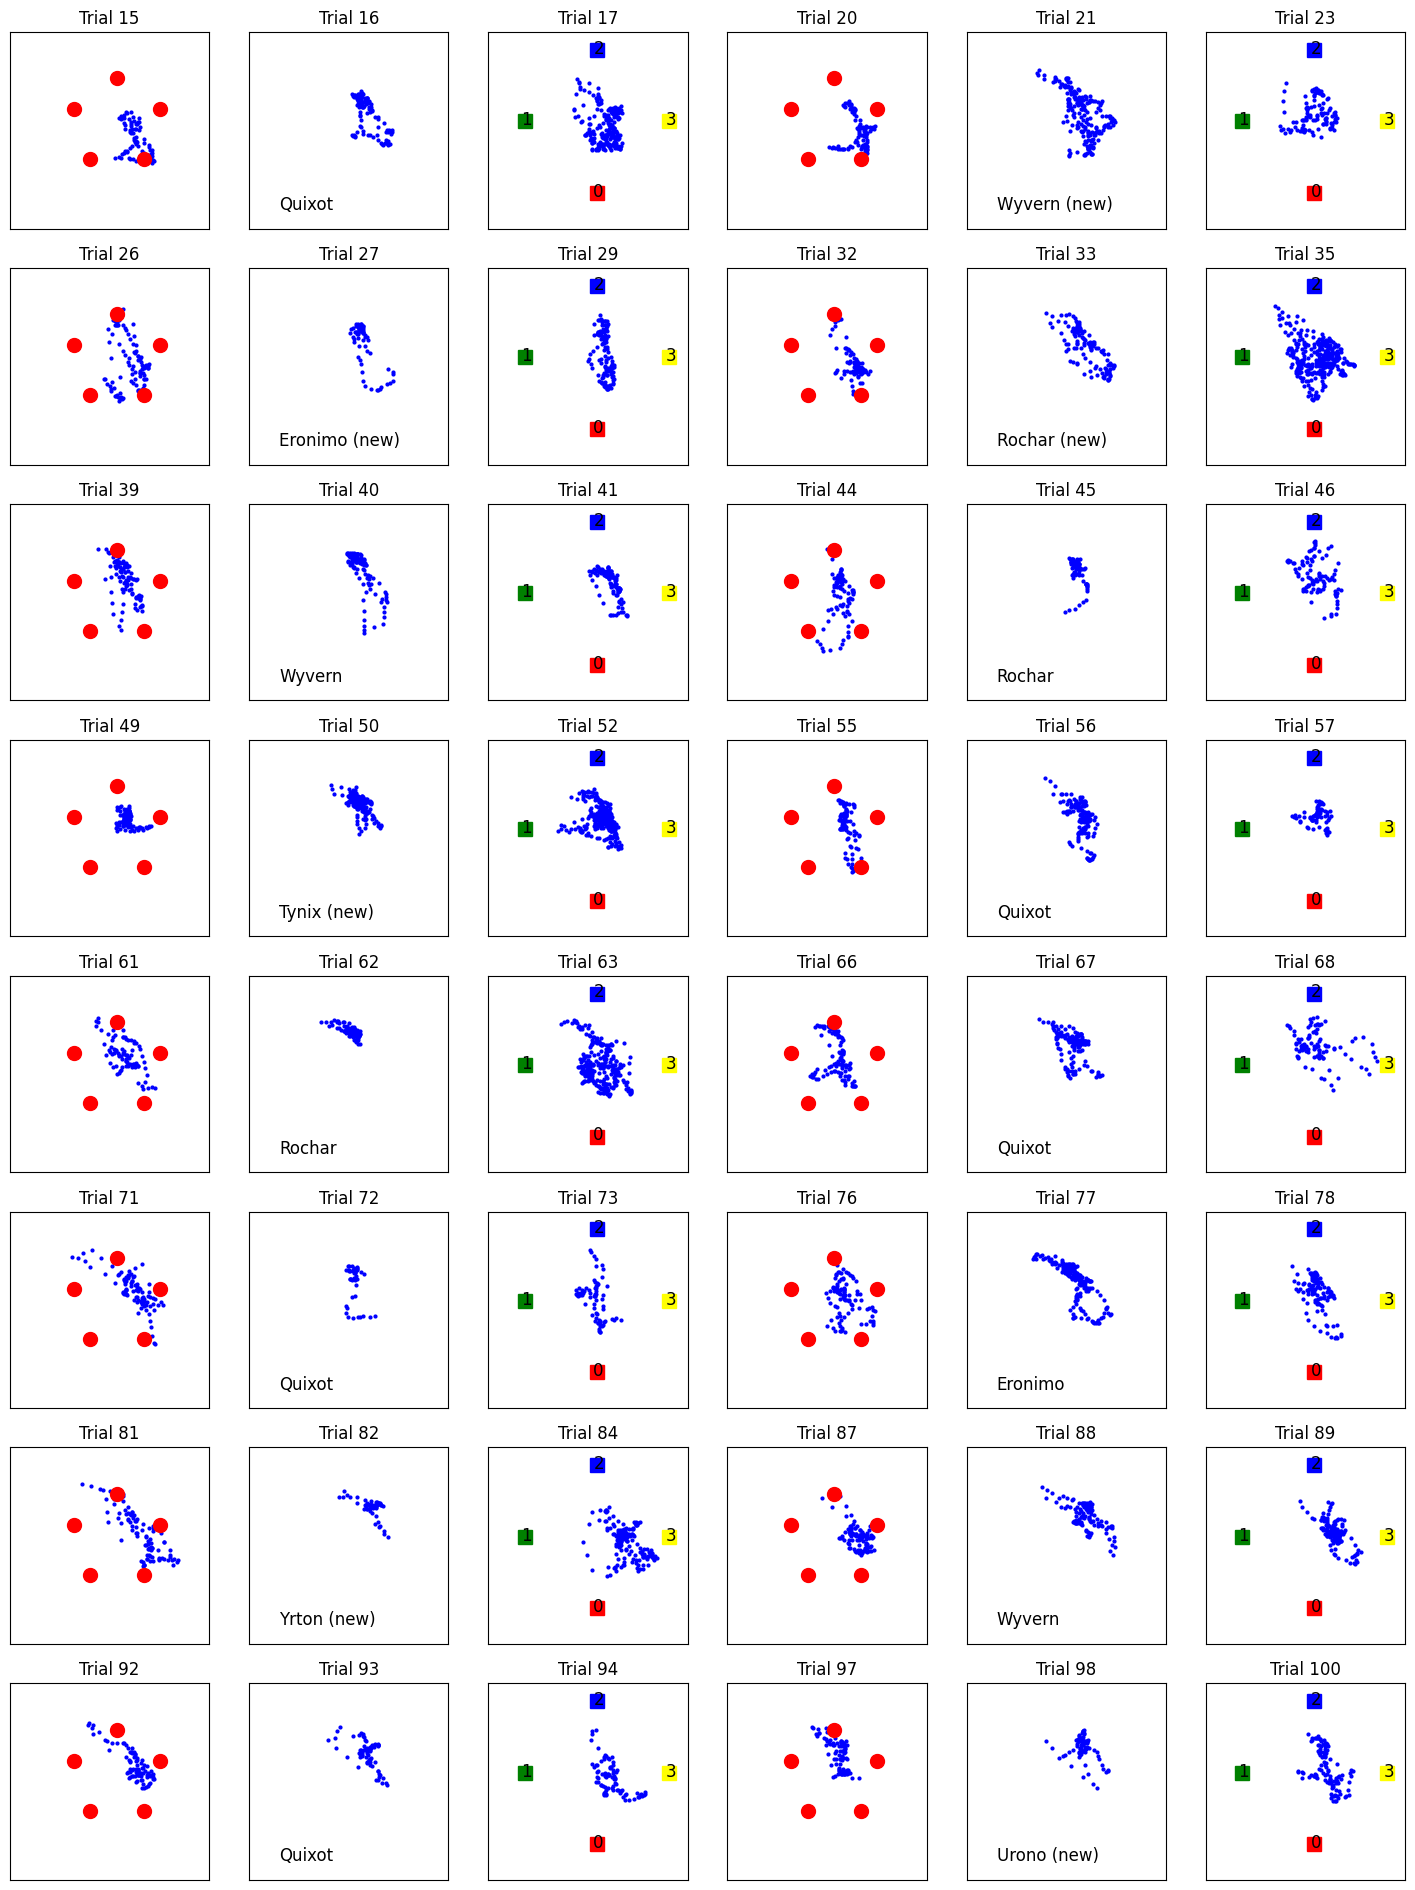

In [7]:
def visualize_experiment_eyegaze(preprocessed_experiment):
    '''For each trial, show a white image where the eye gaze data is drawn as dots'''
    print(f'Visualizing eye gaze experiment {preprocessed_experiment["experiment_id"]}')
    
    n_eye_trials = sum('webgazer_data' in trial for trial in preprocessed_experiment['trials'])
    # print(f'Number of eye trials: {n_eye_trials}')
    cols = 6
    rows = (n_eye_trials + cols - 1) // cols
    fig, axs = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
    trial_i = 0
    for trial in preprocessed_experiment['trials']:
        if 'webgazer_data' in trial:
            bucket_centers = [
                [593 + 200/2, -106 + 200/2],
                [193 + 200/2, 294 + 200/2],
                [593 + 200/2, 694 + 200/2],
                [993 + 200/2, 294 + 200/2],
            ]
            bucket_colors = ['red', 'green', 'blue', 'yellow']
            if rows == 1:
                ax = axs[trial_i % cols]
            else:
                ax = axs[trial_i // cols, trial_i % cols]
            ax.set_title(f'Trial {trial['trial_index']}')
            ax.set_xlim(min([b[0] for b in bucket_centers]) - 200, max([b[0] for b in bucket_centers]) + 100)
            ax.set_ylim(min([b[1] for b in bucket_centers]) - 200, max([b[1] for b in bucket_centers]) + 100)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

            for i, point in enumerate(trial['webgazer_data']):
                ax.plot(point['x'], point['y'], 'o', markersize=2, color='blue')
            trial_i += 1

            if trial['trial_type'] == 'dragndrop':
                for i, bucket_center in enumerate(bucket_centers):
                    ax.plot(bucket_center[0], bucket_center[1], 's', markersize=10, color=bucket_colors[i])
                    ax.text(bucket_center[0]-20, bucket_center[1]-20, str(i), fontsize=12, color='black')
                
            elif trial['trial_type'] == 'html-keyboard-response':
                # draw 5 circles around the center with equal angle distance and radius 100
                radius = 250
                center = [583 + 200/2, 284 + 200/2]
                for i in range(5):
                    angle = i * 2 * np.pi / 5
                    x = center[0] + radius * np.sin(angle)
                    y = center[1] + radius * np.cos(angle)
                    ax.plot(x, y, 'o', markersize=10, color='red')
                # ax.plot(center[0], center[1], 'o', markersize=10, color='red')
            
            elif trial['trial_type'] == 'html-button-response':
                ax.text(260, -100, f'{trial["estimated_state"]}' + (' (new)' if trial['new_state'] else ''), fontsize=12, color='black')
    plt.show()

visualize_experiment_eyegaze(experiments[0])


Visualizing mouse data experiment G587cML7Z7SnWNWPUy4f


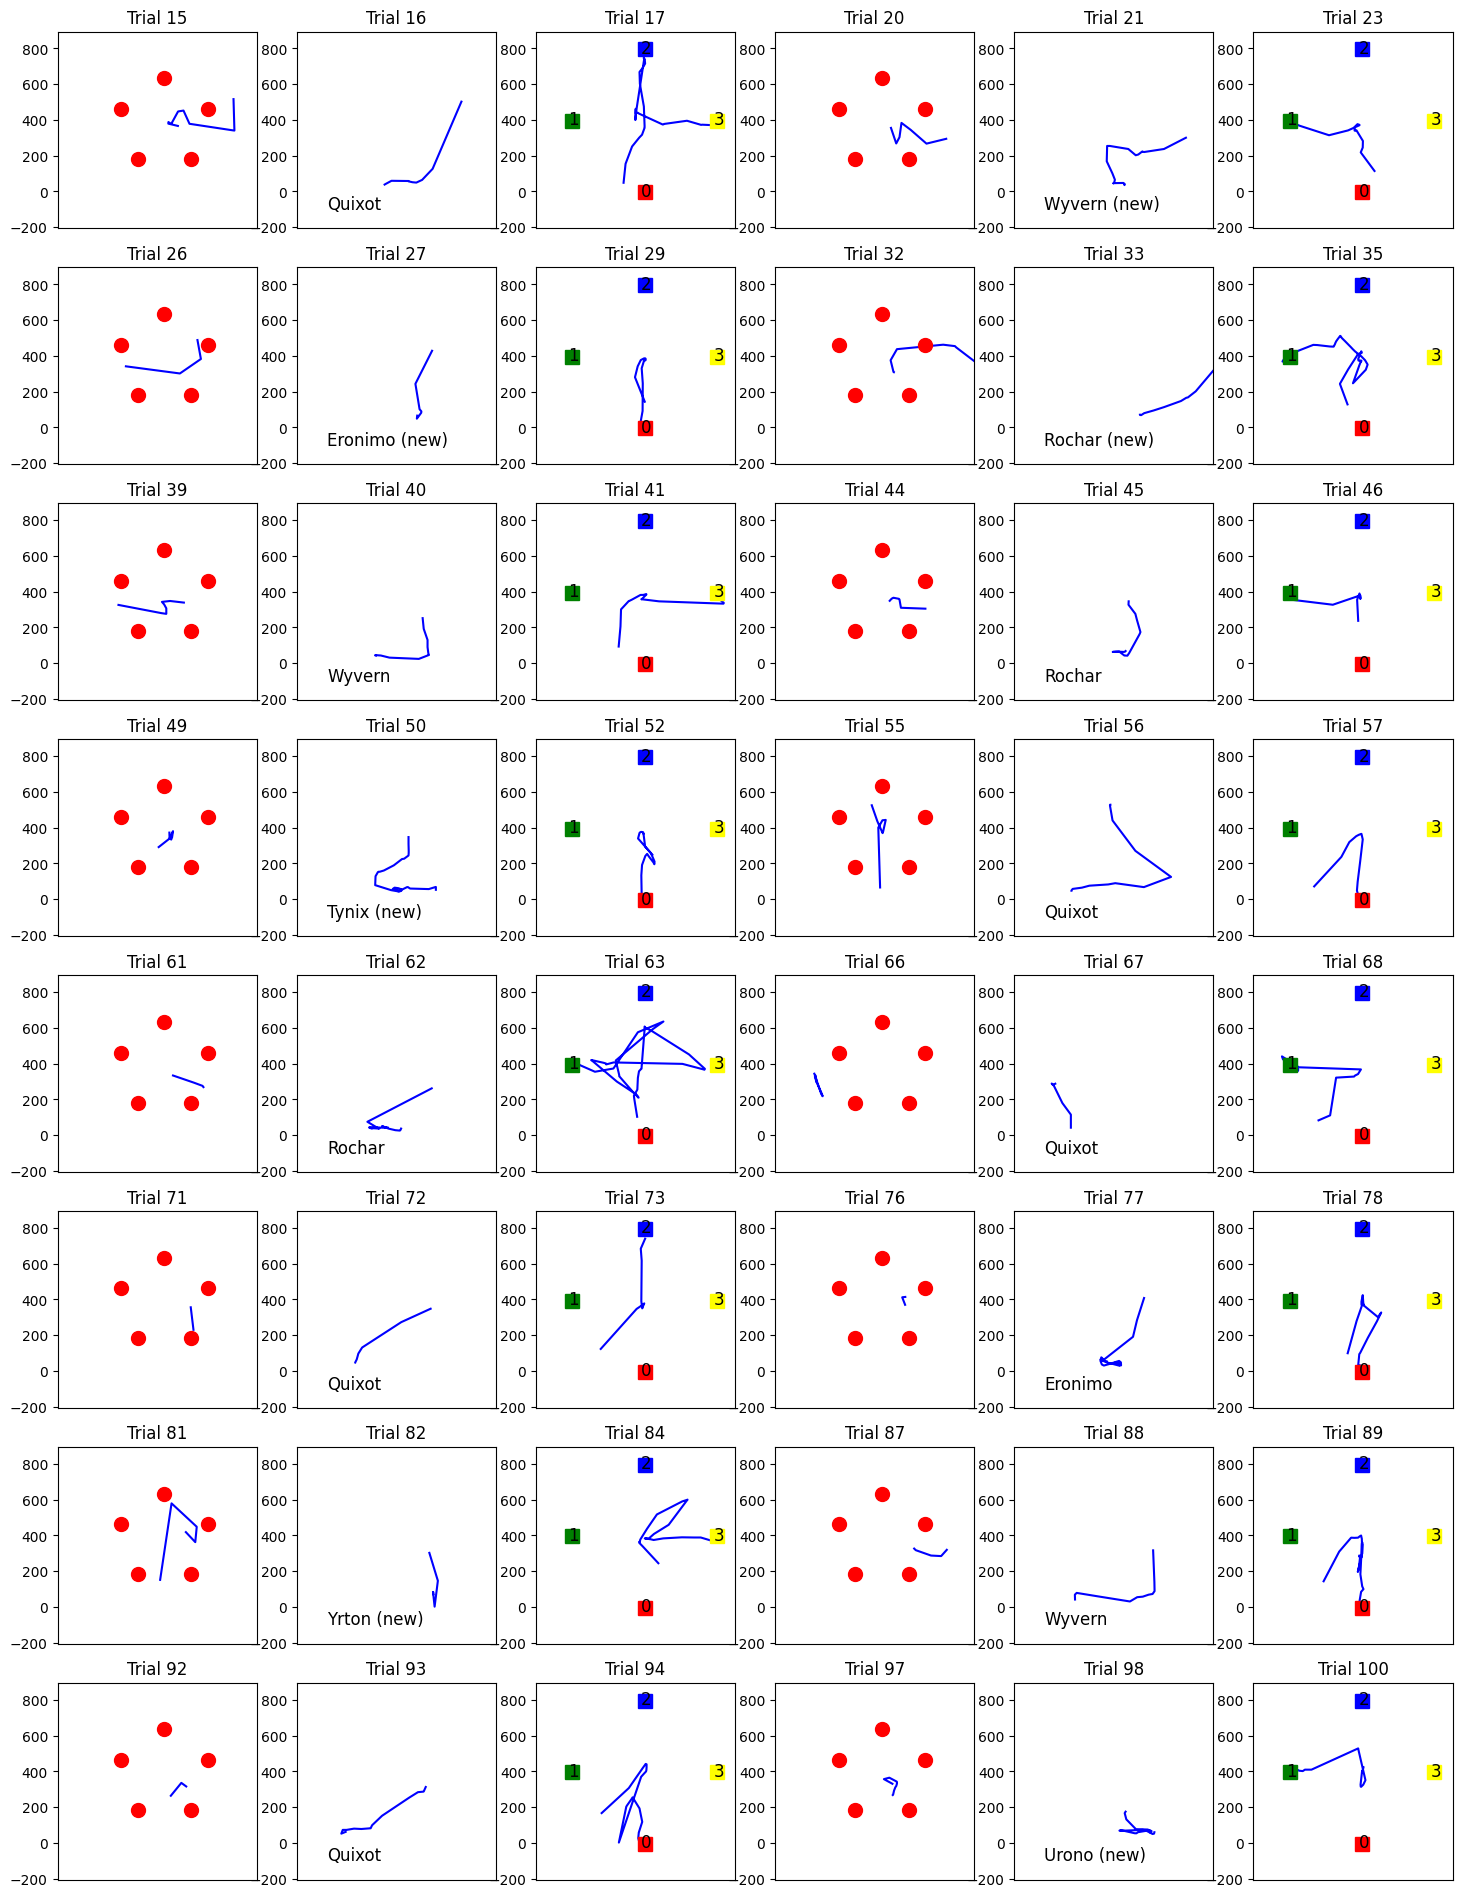

In [8]:
def visualize_experiment_mouse_data(preprocessed_experiment):
    '''For each trial, show a white image where the mouse data is drawn as lines'''
    print(f'Visualizing mouse data experiment {preprocessed_experiment["experiment_id"]}')
    
    n_mouse_trials = sum('mouse_tracking_data' in trial for trial in preprocessed_experiment['trials'])
    # print(f'Number of mouse trials: {n_mouse_trials}')
    cols = 6
    rows = (n_mouse_trials + cols - 1) // cols
    fig, axs = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
    trial_i = 0
    for trial in preprocessed_experiment['trials']:
        if 'mouse_tracking_data' in trial:
            bucket_centers = [
                [593 + 200/2, -106 + 200/2],
                [193 + 200/2, 294 + 200/2],
                [593 + 200/2, 694 + 200/2],
                [993 + 200/2, 294 + 200/2],
            ]
            bucket_colors = ['red', 'green', 'blue', 'yellow']
            if rows == 1:
                ax = axs[trial_i % cols]
            else:
                ax = axs[trial_i // cols, trial_i % cols]
            ax.set_title(f'Trial {trial['trial_index']}')
            ax.set_xlim(min([b[0] for b in bucket_centers]) - 200, max([b[0] for b in bucket_centers]) + 100)
            ax.set_ylim(min([b[1] for b in bucket_centers]) - 200, max([b[1] for b in bucket_centers]) + 100)
            ax.get_xaxis().set_visible(False)
            # ax.get_yaxis().set_visible(False)

            center = [583 + 200/2, 284 + 200/2]
            ax.plot(
                [d['x'] for d in trial['mouse_tracking_data']], 
                [center[1] - (d['y']-center[1]) for d in trial['mouse_tracking_data']],
                label='Mouse data', color='blue'
            )
            
            if trial['trial_type'] == 'dragndrop':
                for i, bucket_center in enumerate(bucket_centers):
                    ax.plot(bucket_center[0], bucket_center[1], 's', markersize=10, color=bucket_colors[i])
                    ax.text(bucket_center[0]-20, bucket_center[1]-20, str(i), fontsize=12, color='black')
                
            elif trial['trial_type'] == 'html-keyboard-response':
                # draw 5 circles around the center with equal angle distance and radius 100
                radius = 250
                for i in range(5):
                    angle = i * 2 * np.pi / 5
                    x = center[0] + radius * np.sin(angle)
                    y = center[1] + radius * np.cos(angle)
                    ax.plot(x, y, 'o', markersize=10, color='red')
                # ax.plot(center[0], center[1], 'o', markersize=10, color='red')
            
            elif trial['trial_type'] == 'html-button-response':
                ax.text(260, -100, f'{trial["estimated_state"]}' + (' (new)' if trial['new_state'] else ''), fontsize=12, color='black')
            trial_i += 1

    plt.show()

visualize_experiment_mouse_data(experiments[0])